## Exercise 2.1. {-}

In [236]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.optimize as opt

In [237]:
def def_params():
    P = 20. # life period
    β = 0.442 # 1-pd discount factor = 0.96 ==> 20yr factor = 0.96^20 = 0.442
    δ = 0.6415 # 1-pd depr factor = 0.05 ==> 20yr factor = 1-(1-0.05)^20 = 0.6415
    σ = 3. # CRRA coefficient
    A = 1. # productivity scale param of firms
    α = 0.35 # income capital share
    return P,β,δ,σ,A,α

In [238]:
def feasible(f_params, bvec_guess):
    
    nvec, A, α, δ = f_params # f_params = (nvec, A, alpha, delta)
    scalar1, scalar2 = bvec_guess # bvec_guess = np.array([scalar, scalar])    
    
    P,β,δ,σ,A,α = def_params()
    
    
    K = bvec_guess.sum()
    L = nvec.sum()
    I = δ * K
    Y = A * (K ** α) * (L ** (1 - α))
    r = (α * A * ((L / K) ** (1 - α))) - δ
    w = (1 - α) * A * ((K / L) ** α)

    wvec = w * nvec
    
    s = np.array([0, *bvec_guess])
    s_p1 = np.roll(s, len(s)-1)
    
        
    if K <= 0: # for the given f_params and bvec_guess
        K_cnstr = True
    else:
        K_cnstr = False

        
    c = (1 + r) * s + wvec - s_p1
    
    c_cnstr = [False, False, False]
    for i in range(3):
        if c[i] <=0: # given f_params and bvec_guess
            c_cnstr[i] = True

    b_cnstr = [False, False]
    if c_cnstr[0] == True:
        b_cnstr[0] = True
    if c_cnstr[1] == True:
        b_cnstr[0], b_cnstr[1] = True, True
    if c_cnstr[2] == True:
        b_cnstr[1] = True
        
    return np.array(b_cnstr), np.array(c_cnstr), np.array(K_cnstr)

In [241]:
def problem2_1(scalar1=float, scalar2=float):
    P,β,δ,σ,A,α = def_params()
    
    nvec = np.array([1., 1., 0.2])
    
    f_params = (nvec, A, α, δ)
    bvec_guess = np.array([scalar1, scalar2])

    b_cnstr, c_cnstr, K_cnstr = feasible(f_params, bvec_guess)
        
    print(
        "*  b_cnstr: "+str(b_cnstr)+
        "\n*  c_cnstr: "+str(c_cnstr)+
        "\n*  K_cnstr: "+str(K_cnstr)
    )
    return bvec_guess

#### Question (a). {-}
$\textit{Which, if any, of the constraints is violated if you choose an initial guess for steady-state savings of }\mathtt{bvec\_guess = np.array([1.0, 1.2])}?$

In [242]:
problem2_1(1.0, 1.2)

*  b_cnstr: [ True False]
*  c_cnstr: [ True False False]
*  K_cnstr: False


array([1. , 1.2])

Consumption positivity violated for $s=1$.

#### Question (b). {-}
$\textit{Which, if any, of the constraints is violated if you choose an initial guess for steady-state savings of }\mathtt{bvec\_guess = np.array([0.06, -0.001])}?$

In [243]:
problem2_1(0.06, -0.001)

*  b_cnstr: [False False]
*  c_cnstr: [False False False]
*  K_cnstr: False


array([ 0.06 , -0.001])

None of the constraints are violated.

#### Question (c). {-}
$\textit{Which, if any, of the constraints is violated if you choose an initial guess for steady-state savings of }\mathtt{bvec\_guess = np.array([0.1, 0.1])}?$

In [244]:
problem2_1(0.1, 0.1)

*  b_cnstr: [False False]
*  c_cnstr: [False False False]
*  K_cnstr: False


array([0.1, 0.1])

None of the constraints are violated.

## Exercise 2.2. {-}

In [245]:
def dudc(c, σ=3):
    if c == 0:
        return np.inf 
    else:
        return c ** (-σ)

#### Question (a) {-}
Solve numerically for the steady-state equilibrium values of $\{\bar{c}_{s}\}_{s=1}^{3} , \{\bar{b}_s\}_{s=1}^{3} , \bar{w}, \bar{r}, \bar{K}, \bar{Y}, \bar{C}$, the two Euler errors, and the resource constraint error. List those values. Time your function. How long did it take to compute the steady-state?

#### Question (b) {-}
Generate a figure that shows the steady-state distribution of consumption and savings by age $\{\bar{c}\}_{s=1}^{3}$ and $\{\bar{b}_s\}_{s=2}^3$.

In [458]:
def errors(bvec_guess):
    
    P,β,δ,σ,A,α=def_params()
    
    nvec = np.array([1., 1., 0.2])
    
    K,L = bvec_guess.sum(), nvec.sum()
    
    r,w = (α * A * ((L / K) ** (1 - α))) - δ, (1 - α) * A * ((K / L) ** α)

    c = ((1+r) * np.array([0,bvec_guess[0],bvec_guess[1]]) + w * nvec - 
    np.roll(np.array([0,bvec_guess[0],bvec_guess[1]]), 
            len(np.array([0,bvec_guess[0],bvec_guess[1]]))-1))
    
    return (np.array([β*(1+r)*dudc(c[e+1])-dudc(c[e]) for e in 
                     range(len(np.array([0,bvec_guess[0],bvec_guess[1]]))-1)]))

In [474]:
def ss(params=def_params(), bvec_guess=np.array([.1, .1])):
    
    start = time.clock()
    
    P,β,δ,σ,A,α=def_params()
    
    nvec = np.array([1., 1., 0.2])
    
    results = opt.root(errors, bvec_guess)
    
    ### steady state vars ###
    b_ss = np.array([*results.x, 0])
    L_ss = nvec.sum()
    Y_ss = A * (b_ss.sum() ** α) * (L_ss ** (1 - α))
    r_ss = (α * A * ((L_ss / b_ss.sum()) ** (1 - α))) - δ
    w_ss = (1 - α) * A * ((b_ss.sum() / L_ss) ** α)
    c_ss = ((1+r_ss) * np.roll(b_ss,len(b_ss)-1)) + (w_ss*nvec) - b_ss
    #########################
    
    stop = time.clock() - start
    
    plt.subplot(211)
    plt.plot(c_ss,"m--o")
    plt.title("Steady State Consumption")
    plt.xlabel("Age")
    plt.ylabel("Consumption")

    plt.subplot(212)
    plt.plot(b_ss,"c--o")
    plt.title("Steady State Savings")
    plt.xlabel("Age")
    plt.ylabel("Savings")

    plt.tight_layout()
    
    return (b_ss, c_ss, w_ss, r_ss, b_ss.sum(), Y_ss, c_ss.sum(), 
            results.fun, Y_ss - c_ss.sum()-δ*b_ss.sum(), stop)

In [475]:
def problem2_2_1():
    ss()

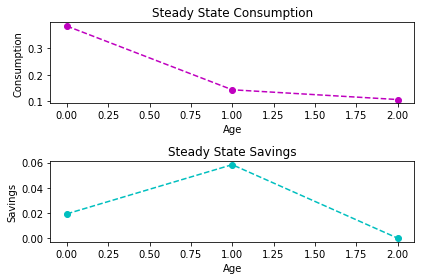

In [476]:
problem2_2_1()

#### Question (c) {-}
What happens to each of these steady-state values if all households become more patient $\beta\uparrow$ (an example would be $\beta=0.55$)? That is, in what direction does $\beta\uparrow$ move each steady-state value $\{\bar{c}_s\}_{s=1}^{3},\{\bar{b}_s\}_{s=1}^{3},\bar{w},$ and $\bar{r}$? What is the intuition?

In [477]:
def problem2_2_2():
    
    P,β,δ,σ,A,α=def_params()
    
    ss(params=(P,0.55,δ,σ,A,α))

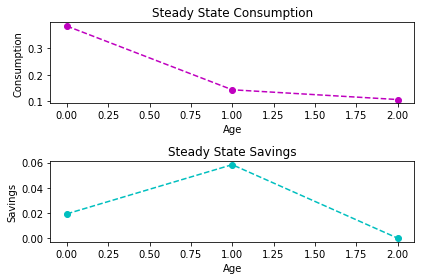

In [478]:
problem2_2_2()

## Exercise 2.3 {-}

#### Question (a) {-}
Report the maximum of the absolute values of all the Euler errors across the entire time path. Also report the maximum of the absolute value of all the aggregate resource constraint errors $Y_t - C_t - K_{t+1} + (1-\delta)K_t$ across the entire time path.

In [479]:
def errors_1(sav, w=None,r=None,nvec=None,bvec_guess=np.array([.1, .1]),s=None,t=None):
        
    P,β,δ,σ,A,α=def_params()
    tol=1e-12
    
    if nvec is None:
        nvec = np.array([1.,1.,0.2])
    
    K = bvec_guess.sum()
    L = nvec.sum()
    
    if r is None and w is None:
        r = (α * A * ((L / K) ** (1 - α))) - δ
        w = (1 - α) * A * ((K / L) ** α)
    
    return (dudc(w[t] * nvec[s] - sav) - β * (1+r[t+1]) * 
            dudc((1+r[t+1]) * sav + w[t+1] * nvec[s+1]))

In [480]:
def errors_2(sav,w=None,r=None,nvec=None,bvec_guess=np.array([.1, .1]),s=None,t=None):
    

    P,β,δ,σ,A,α=def_params()
    tol=1e-12
    
    if nvec is None:
        nvec = np.array([1.,1.,0.2])
    
    K = bvec_guess.sum()
    L = nvec.sum()
    
    if r is None and w is None:
        r = (α * A * ((L / K) ** (1 - α))) - δ
        w = (1 - α) * A * ((K / L) ** α)
    
    
    e=[]
    
    e.append( (dudc(w[t] - sav[0]) - β * (1+r[t+1]) * 
               dudc(w[t+1] + (1+r[t+1]) * sav[0] - sav[1])))
    
    e.append( (dudc(w[t+1] + (1 + r[t+1]) * sav[0] - sav[1]) - β * 
              (1+r[t+2]) * dudc(nvec[s+1] * w[t+1] + (1 + r[t+2]) * sav[1])))
    
    return np.array(e)

In [481]:
def path_plot(S=3, P=50, x=0.3, tol=1e-12, bvec_guess=np.array([.1, .1])):
    
    P,β,δ,σ,A,α=def_params()
    
    nvec = np.array([1.,1.,0.2])
    
    K = bvec_guess.sum()
    L = nvec.sum()
    
    r = (α * A * ((L / K) ** (1 - α))) - δ
    w = (1 - α) * A * ((K / L) ** α)

    wag = w * nvec
    sav = np.array([0,bvec_guess[0],bvec_guess[1]])
    
    K_guess = np.linspace(np.array([0,0.8*ss()[0][0],1.1*ss()[0][1]]).sum(),ss()[4], P)
    
    s = 1
    K_pr = K_guess
    b_t = np.zeros((S,int(P)))
    b_t[:,0] = np.array([0,0.8*ss()[0][0], 1.1*ss()[0][1]])
    
    count = 0
    norm = 10.
    while norm>tol:
        w_pr = w = (1 - α) * A * ((K_pr / L) ** α)
        r_pr = r = (α * A * ((L / K_pr) ** (1 - α))) - δ
        for t in range(int(P)-2):

            b_t[s+1,t+1] = opt.root(errors_1, 0, args = (w_pr,r_pr,nvec,b_t[:,t],s,t)).x

            b_t[s,t+1],b_t[s+1, t+2] = opt.root(errors_2, [0,0], args=(w_pr, r_pr, nvec, np.array([0, 0.8 * ss()[0][0], 1.1 * ss()[0][1]]), s, t)).x

            b_t[s][int(P)-1] = b_t[s][int(P)-2]
        
        norm = max((b_t.sum(axis=0) - K_pr))

        count += 1
        print("•  Iteration:",count,"\n•  Normed difference:",norm,"\n")

        K_pr = x * b_t.sum(axis=0) + (1-x) * K_pr
    
    plt.subplot(311)
    plt.plot(range(int(P)), K_guess, "m-o", label="$\mathtt{K\_guess}$")
    plt.plot(range(int(P)), K_pr, "g-o", label="$K$")
    plt.title("$K$ and $\mathtt{K\_guess}$ paths")
    plt.xlabel("$t$")
    plt.ylabel("$K$")
    plt.legend()
    
    plt.subplot(312)
    plt.plot(range(int(P)), r_pr, "c-o",label="$r$ Path")
    plt.title("$r$ Path")
    plt.xlabel("$t$")
    plt.ylabel("$r$")
    
    plt.subplot(313)
    plt.plot(range(int(P)), w_pr, "b-o")
    plt.title("$w$ Path")
    plt.xlabel("$t$")
    plt.ylabel("$w$")
    
    plt.tight_layout()
    plt.show()
    
    return K_pr

In [482]:
def problem2_3_1():
    path_plot()

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  app.launch_new_instance()


•  Iteration: 1 
•  Normed difference: 6.9880809747902e-05 

•  Iteration: 2 
•  Normed difference: 0.0 



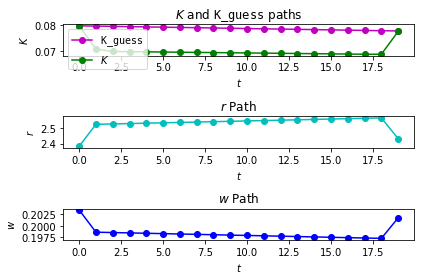

In [483]:
problem2_3_1()

#### Question (b) {-}
Plot the equilibrium time paths of the aggregate capital stock $\{K_t\}_{t=1}^{T+5}$, wage $\{w_t\}_{t=1}^{T+5}$, and interest rate $\{r_t\}_{t=1}^{T+5}$.

In [484]:
def problem2_3_2():
    print(path_plot())

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  app.launch_new_instance()


•  Iteration: 1 
•  Normed difference: 6.9880809747902e-05 

•  Iteration: 2 
•  Normed difference: 0.0 



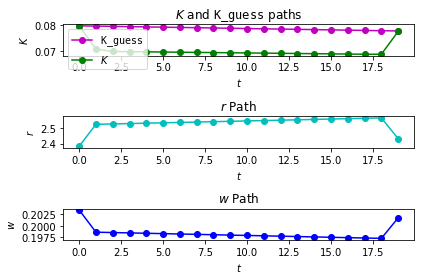

[0.07970223 0.07071408 0.06983842 0.06976714 0.06969583 0.06962452
 0.06955318 0.06948183 0.06941046 0.06933908 0.06926768 0.06919627
 0.06912483 0.06905339 0.06898192 0.06891044 0.06883894 0.06876743
 0.06877418 0.07752646]


In [485]:
problem2_3_2()

#### Question (c) {-}
How many periods did it take for the economy to get within $0.00001$ of the steady-state aggregate capital stock $\bar K$? What is the period after which the aggregate capital stock never is again farther than the $0.00001$ away from the steady-state?

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  app.launch_new_instance()


•  Iteration: 1 
•  Normed difference: 6.9880809747902e-05 

•  Iteration: 2 
•  Normed difference: 0.0 



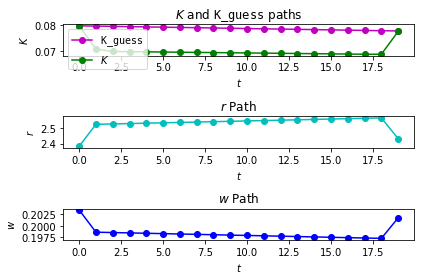

0


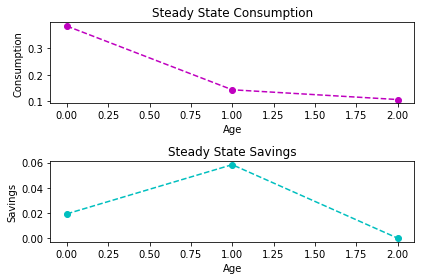

In [486]:
print(np.argmax(np.abs(path_plot()-ss()[4])<0.0001))